In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import os
import re
import string
import nltk
import datetime as dt

from statistics import mean
from tqdm.notebook import tqdm,tnrange
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as SIA_VADER
from nltk.sentiment import SentimentIntensityAnalyzer as SIA_NLTK

import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.style as style 
import seaborn as sns

sns.set_style('darkgrid')
sns.set_context('paper')
style.use('ggplot')
matplotlib.rcParams['font.family'] = 'helvetica'
matplotlib.rcParams['figure.titlesize'] = 'large'

In [2]:
def import_submissions_df():
    path = './submissions_scraped/'
    files = []
    for filename in os.listdir(path):
        files.append(pd.read_csv(os.path.join(path, filename)))

    files = pd.concat(files)
    df_submissions = pd.DataFrame(files)
    df_submissions.drop(columns=['Unnamed: 0'], inplace=True)
    df_submissions.dropna(inplace=True)
    return df_submissions

In [3]:
def import_comments_df():
    df_comments = pd.read_csv('./comments_scraped/comments.csv')
    df_comments.drop(columns=['Unnamed: 0'], inplace=True)
    df_comments.dropna(inplace=True)
    return df_comments

In [4]:
def clean_text(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower()
    text = re.sub('^\[removed\]|^\[deleted\]', '', str(text))
    text = re.sub('^\[deleted by user\]', '', str(text))
    text = re.sub('^nan', '', str(text))
    text = re.sub(r'#', '',  str(text))
    text = re.sub(r"(?:\@|https?\://)\S+", "", str(text))
    text = re.sub(r'[^\x00-\x7f]',r'', str(text))
    text = re.sub(r'www\S+', '',  str(text)) 
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

In [5]:
def is_positive(compound):
    if compound > 0.05:
        return 1
    elif compound < -0.05:
        return -1
    else:
        return 0

In [6]:
subreddits = ['CrohnsDisease', 'IBD', 'UlcerativeColitis', 'ibs']
colors = ['#cc5a49', '#4586ac', '#9e97cc', '#777777']

df_submissions = import_submissions_df()
df_comments = import_comments_df()

df_submissions = df_submissions[df_submissions['body'] != '']
df_comments = df_comments[df_comments['body'] != '']

df_submissions['created'] = pd.to_datetime(df_submissions['created'])
df_comments['created'] = pd.to_datetime(df_comments['created'])

In [7]:
df = pd.concat([df_submissions, df_comments])
df.body = df.body.apply(lambda x: clean_text(str(x)))
df.title = df.title.apply(lambda x: clean_text(str(x)))

In [8]:
df['title_and_body'] = df['title'] + ' ' + df['body']
df['title_and_body'] = df['title_and_body'].apply(lambda x: clean_text(x))
df = df[df['title_and_body'] != '']

### Analysis of data usign vader, nltk and nltk with tokenization

In [9]:
sia_vader = SIA_VADER()
sia_nltk = SIA_NLTK()

In [10]:
sentiments = []
for post in tqdm(df.title_and_body, desc='Analyzing with vader'):
    sentiments.append(sia_vader.polarity_scores(post))
    
df['sia_vader'] = sentiments

compounds = []
for sent_dict in df.sia_vader.iloc[0:]:
    compounds.append(sent_dict['compound'])

df['compound_vader'] = compounds

Analyzing with vader:   0%|          | 0/379573 [00:00<?, ?it/s]

In [11]:
sentiments = []
for post in tqdm(df.title_and_body, desc='Analyzing with nltk'):
    sentiments.append(sia_nltk.polarity_scores(post))

df['sia_nltk'] = sentiments

compounds = []
for sent_dict in df.sia_vader.iloc[0:]:
    compounds.append(sent_dict['compound'])

df['compound_nltk'] = compounds

Analyzing with nltk:   0%|          | 0/379573 [00:00<?, ?it/s]

In [12]:
df['label_vader'] = df.compound_vader.apply(lambda x: is_positive(x))
df['label_nltk'] = df.compound_nltk.apply(lambda x: is_positive(x))

In [13]:
print(df.label_vader.value_counts())
print(df.label_nltk.value_counts())

 1    190666
-1    126406
 0     62501
Name: label_vader, dtype: int64
 1    190666
-1    126406
 0     62501
Name: label_nltk, dtype: int64


In [14]:
def is_positive_2(text):        
    scores = [
        sia_nltk.polarity_scores(sentence)['compound'] 
        for sentence in nltk.sent_tokenize(text)
    ]
    if len(scores) > 0:
        if mean(scores) > 0.05:
            return 1
        elif mean(scores) < -0.05:
            return -1
        else:
            return 0
    else:
        return 0

In [15]:
sentiments = []
for text in tqdm(df.title_and_body.iloc[0:], desc='Analyzing with nltk and tokenization'):
    sentiments.append(is_positive_2(text))

df['label_nltk_with_tokens'] = sentiments

Analyzing with nltk and tokenization:   0%|          | 0/379573 [00:00<?, ?it/s]

In [23]:
df.label_nltk_with_tokens.value_counts()

 1    188375
-1    128762
 0     62436
Name: label_nltk_with_tokens, dtype: int64

There is no much difference between the algorithms and the tokenization seems to produce similar results

In [24]:
%%capture

df_nltk_with_tokens = df[['label_nltk_with_tokens', 'created']]
df_nltk = df[['label_nltk', 'created']]
df_vader = df[['label_vader', 'created']]

df_nltk_with_tokens['algorithm'] = 'nltk with tokenization'
df_vader['algorithm'] = 'vader'
df_nltk['algorithm'] = 'nltk'

df_nltk_with_tokens.rename(columns={'label_nltk_with_tokens': 'label'}, inplace=True)
df_vader.rename(columns={'label_vader': 'label'}, inplace=True)
df_nltk.rename(columns={'label_nltk': 'label'}, inplace=True)

df_results = pd.concat([df_nltk, df_vader, df_nltk_with_tokens], ignore_index=True)

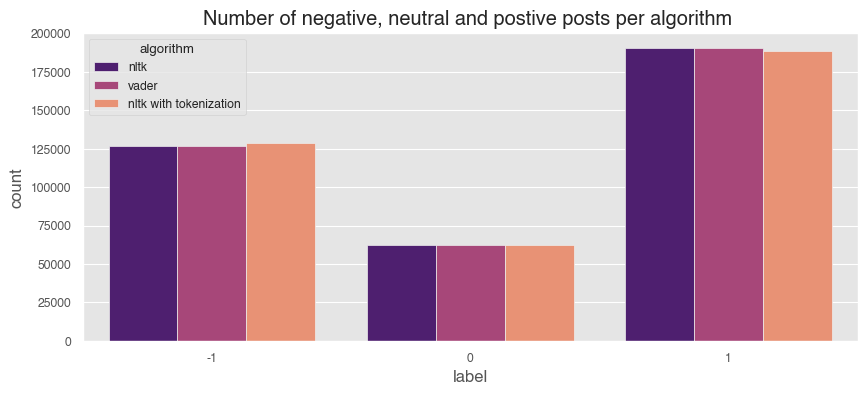

In [144]:
fig, ax = plt.subplots(figsize=(10,4))

sns.countplot(x='label', hue='algorithm', data=df_results, palette='magma')
plt.title('Number of negative, neutral and postive posts per algorithm ')
plt.show();

From now the analysis will use vader as the main algorithm

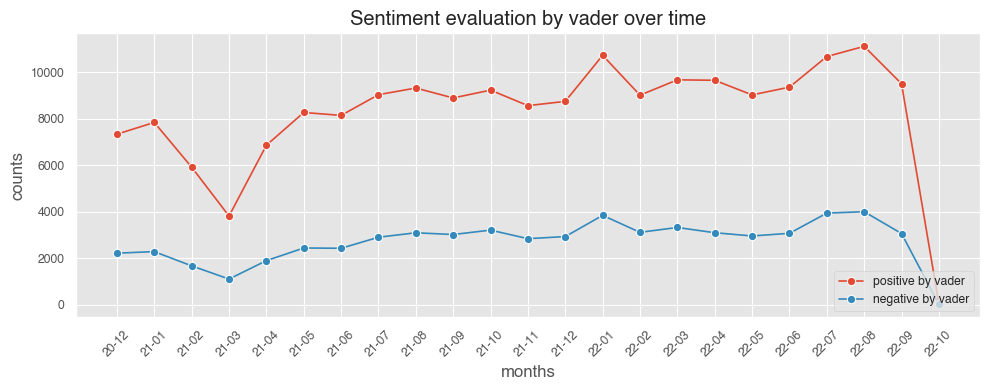

In [26]:
v_pos = df_vader[df_vader['label'] == 1]
v_neg = df_vader[df_vader['label'] == 0]

v_pos = v_pos['created'].dt.strftime('%y-%m').value_counts().sort_index().reset_index(name='counts')
v_neg = v_neg['created'].dt.strftime('%y-%m').value_counts().sort_index().reset_index(name='counts')

df_v_pos = pd.DataFrame(v_pos)
df_v_neg = pd.DataFrame(v_neg)

df_v_pos = df_v_pos.rename(columns={'index': 'months'}).reset_index()
df_v_neg = df_v_neg.rename(columns={'index': 'months'}).reset_index()

plt.figure(figsize=(10, 4))
plt.title('Sentiment evaluation by vader over time')
sns.lineplot(x=df_v_pos.months, y=df_v_pos.counts, marker='o', markersize=6, label='positive by vader');
sns.lineplot(x=df_v_neg.months, y=df_v_neg.counts, marker='o', markersize=6, label='negative by vader')
plt.xticks(rotation = 45)

plt.legend(loc='lower right')
plt.tight_layout()
plt.show();

The plot shows that much more data are labelled as positive than negative.  

There is a max and min peek between **December 2021** and **February 2022**. Then another one during **July and August 2022**. 

In [27]:
compound_vader = []
for entry in df.sia_vader:
    compound_vader.append(entry['compound'])

df_vader['compound'] = compound_vader

In [28]:
df_vader.created = df_vader.created.apply(lambda x : x.strftime('%y-%m'))

sentiment_by_month = df_vader.groupby('created').sum('compound').compound.values
number_of_posts_over_time = df_vader.groupby('created').count().compound.values
avg_sentiments = []
for i in range(0, len(sentiment_by_month)):
    avg_sentiments.append(sentiment_by_month[i] / number_of_posts_over_time[i])

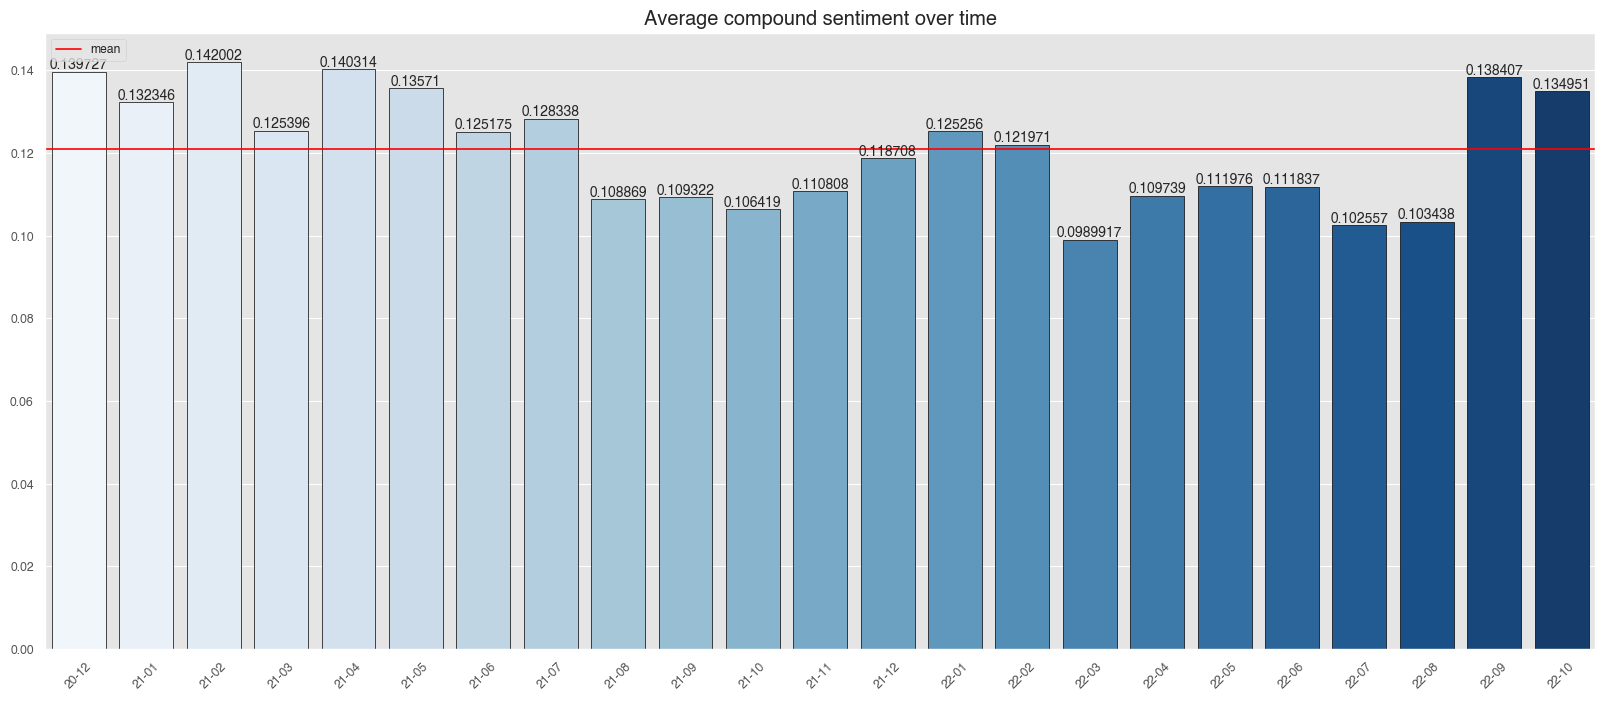

In [310]:
fig, ax = plt.subplots(figsize=(20,8))
plt.title('Average compound sentiment over time')
sns.barplot(x=df_vader.groupby('created').count().compound.keys(), y=avg_sentiments, edgecolor='black', palette='Blues', ax=ax)
plt.xticks(rotation=45)
ax.set_xlabel('')
plt.axhline(mean(avg_sentiments), color='r', label='mean')
ax.bar_label(ax.containers[0])

plt.legend(loc='upper left')
plt.show();

What we could see is that between **August 2021** and **August 2022** the average compound sentiment is slightly under the mean compound.  

The min peek is in **March 2022**.  

It was a key period during the last waves of the pandemic beacuse covid cases increased exponentially as shown [here](https://covid19.who.int).

source: World Health Organization

In [30]:
pos_vader = []
for entry in df.sia_vader:
    pos_vader.append(entry['pos'])

df_vader['pos'] = pos_vader

neg_vader = []
for entry in df.sia_vader:
    neg_vader.append(entry['neg'])

df_vader['neg'] = neg_vader

dates_pos_scores = []
for date in df_vader[df_vader.label == 1].created:
    dates_pos_scores.append(date)
    
dates_neg_scores = []
for date in df_vader[df_vader.label == -1].created:
    dates_neg_scores.append(date)

positive_scores = []
for score in df_vader[df_vader.label == 1].pos:
    positive_scores.append(score)
    
negative_scores = []
for score in df_vader[df_vader.label == -1].neg:
    negative_scores.append(score)

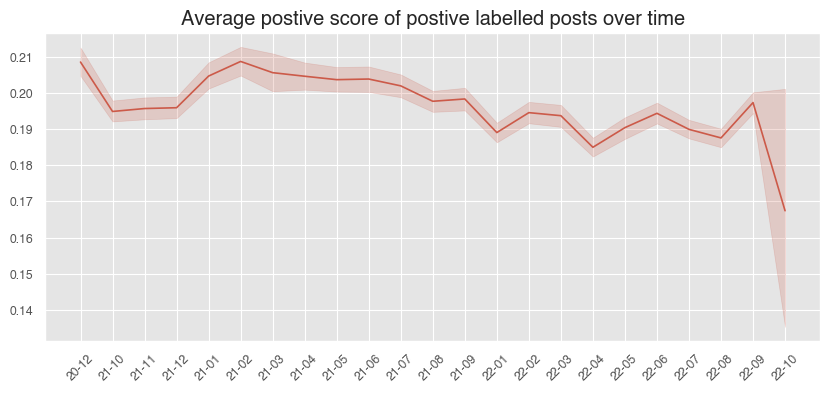

In [36]:
fig, ax = plt.subplots(figsize=(10,4))
plt.title('Average postive score of postive labelled posts over time')
sns.lineplot(x=dates_pos_scores, y=positive_scores, ax=ax, color=colors[0])
plt.xticks(rotation=45)
ax.set_xlabel('')

plt.show();

The positive score of the data decreases over time. 

Altought the data are labelled postively, their positive score tend to decrease over time, escpeccially during the period betweeen **Semptember 2021** and **August 2022**

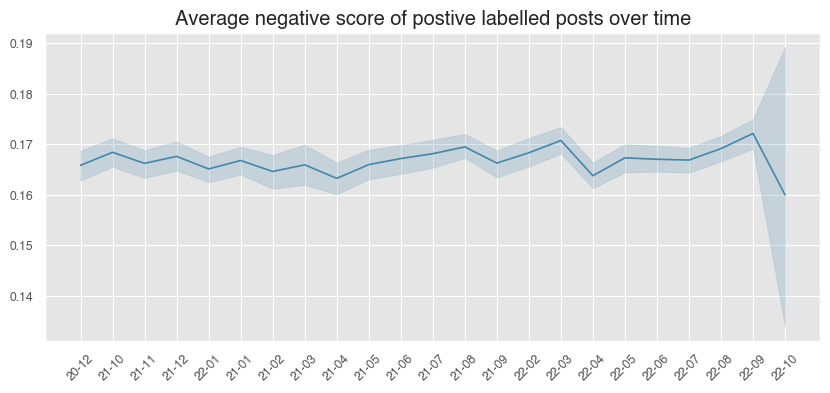

In [32]:
fig, ax = plt.subplots(figsize=(10,4))
plt.title('Average negative score of postive labelled posts over time')
sns.lineplot(x=dates_neg_scores, y=negative_scores, ax=ax, color=colors[1])
plt.xticks(rotation=45)
ax.set_xlabel('')

plt.show();

Data's negative score seems to be constant over time, slightly increasing between **April 2021** and **March 2022**

In [33]:
df_subr = df[['label_vader', 'created', 'subreddit']]
df_subr.rename(columns={'label_vader': 'label'}, inplace=True)

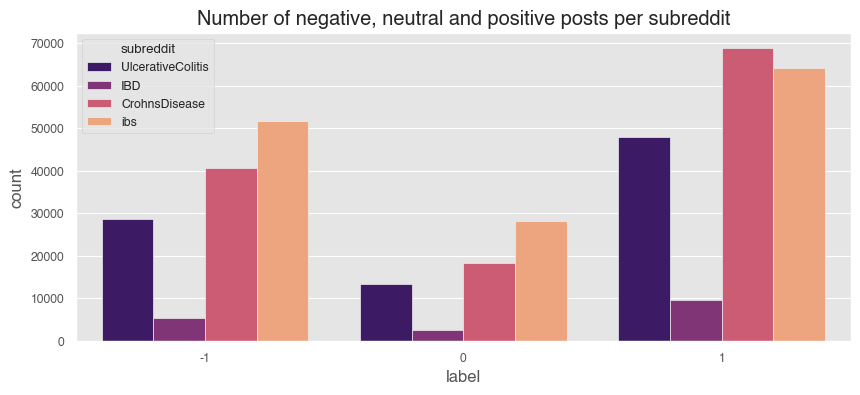

In [143]:
fig, ax = plt.subplots(figsize=(10,4))

sns.countplot(x='label', hue='subreddit', data=df_subr, palette='magma')
plt.title('Number of negative, neutral and positive posts per subreddit')
plt.show();

**r/CrohnsDisease** is the subreddit with more postive texts despite having much less data than **r/ibs**.

For further investigation let's check the actual **sentiment rate** for each subreddit. 

In [132]:
rates = []
for sr in subreddits:
    dd = df_subr[df_subr['subreddit'] == sr]
    dd_pos = dd[dd['label'] == 1]
    dd_neg = dd[dd['label'] == -1]
    dd_neu = dd[dd['label'] == 0]
    pos_rate = dd_pos.shape[0] / df[df['subreddit'] == sr].shape[0]
    neg_rate = dd_neg.shape[0] / df[df['subreddit'] == sr].shape[0]
    neu_rate = dd_neu.shape[0] / df[df['subreddit'] == sr].shape[0]
    
    rates.append((pos_rate, sr, 1))
    rates.append((neg_rate, sr, -1))
    rates.append((neu_rate, sr, 0))
    
rates = pd.DataFrame(rates, columns=['rate', 'subreddit', 'label'])

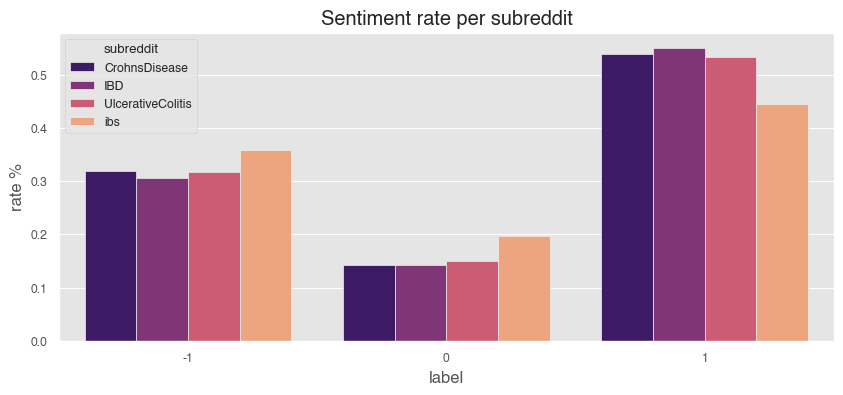

In [142]:
fig, ax = plt.subplots(figsize=(10,4))

sns.barplot(data=rates, x='label', y='rate', hue='subreddit', palette='magma', ax=ax)
plt.title('Sentiment rate per subreddit')
ax.set_ylabel('rate %')
plt.show();

As shown above the sentiment rate changes the perception that we had. 
 
**r/IBD** is the most positive considering the amount of data that it holds.  

**r/ibs** it the most negative but not with the discrepancy shown above.

In [80]:
topfive_positive = df[df['compound_vader'] > 0.9].sort_values(['compound_vader','score'], ascending=False).iloc[0:5]
topfive_positive = topfive_positive[['author', 'score', 'body', 'compound_vader']]

display(topfive_positive)

,author,score,body,compound_vader
409,Health-n-Happiness,29,hopefully the conclusive thread for all your ...,0.9999
12055,Regular_Toast_Crunch,5,it makes sense to be nervous its a big thing a...,0.9997
387,Michento,34,this is really long there is no tldr ive tried...,0.9996
125337,ChronicEverythingMom,1,i suffer from ibd epi myself and i am mother ...,0.9996
29401,altairnaruhodou,18,hello fellow sufferers ibs patient here with ...,0.9995


In [81]:
topfive_negative = df[df['compound_vader'] < 0.9].sort_values(['compound_vader','score'], ascending=True).iloc[0:5]
topfive_negative = topfive_negative[['author', 'score', 'body', 'compound_vader']]

display(topfive_negative)

,author,score,body,compound_vader
16936,Experiment413,6,hi im angel im new to this reddit and i though...,-0.9999
21831,regionalcryptid,6,hey everyone ive come here because i really fe...,-0.9999
13437,Maybe_Thrwwy,5,i know these sort of posts can be very long so...,-0.9996
683,tummypainthrowaway,7,tldr rather sudden onset of symptoms what you ...,-0.9996
31470,DeathbyMuzak,1,hello all first let me say that i am so very...,-0.9994


In [95]:
df[df['label_vader'] == 1].score.sum()

826004

In [96]:
df[df['label_vader'] == -1].score.sum()

645709

In [97]:
df[df['label_vader'] == 0].score.sum()

215593

It seems that the **positive** submissions or comments, earn much more upvotes

In [235]:
df_subr['compound'] = df[['compound_vader']]

df_crohns = df_subr[df_subr['subreddit'] == 'CrohnsDisease']
df_ibd = df_subr[df_subr['subreddit'] == 'IBD']
df_ibs = df_subr[df_subr['subreddit'] == 'ibs']
df_ulc = df_subr[df_subr['subreddit'] == 'UlcerativeColitis']

df_crohns.created = df_crohns.created.apply(lambda x : x.strftime('%y-%m'))
df_ibd.created = df_ibd.created.apply(lambda x : x.strftime('%y-%m'))
df_ibs.created = df_ibs.created.apply(lambda x : x.strftime('%y-%m'))
df_ulc.created = df_ulc.created.apply(lambda x : x.strftime('%y-%m'))

sentiment_crohn_by_month = df_crohns.groupby('created').sum('compound').compound.values
sentiment_ibd_by_month = df_ibd.groupby('created').sum('compound').compound.values
sentiment_ibs_by_month = df_ibs.groupby('created').sum('compound').compound.values
sentiment_ulc_by_month = df_ulc.groupby('created').sum('compound').compound.values

number_of_posts_over_time_crohn = df_crohns.groupby('created').count().compound.values
number_of_posts_over_time_ibd = df_ibd.groupby('created').count().compound.values
number_of_posts_over_time_ibs = df_ibs.groupby('created').count().compound.values
number_of_posts_over_time_ulc = df_ulc.groupby('created').count().compound.values

avg_sentiments_crohn = []
avg_sentiments_ibd = []
avg_sentiments_ibs = []
avg_sentiments_ulc = []

for i in range(0, len(sentiment_crohn_by_month)):
    avg_sentiments_crohn.append(sentiment_crohn_by_month[i] / number_of_posts_over_time_crohn[i])
    
for i in range(0, len(sentiment_ibd_by_month)):
    avg_sentiments_ibd.append(sentiment_ibd_by_month[i] / number_of_posts_over_time_ibd[i])

for i in range(0, len(sentiment_ibs_by_month)):
    avg_sentiments_ibs.append(sentiment_ibs_by_month[i] / number_of_posts_over_time_ibs[i])
    
for i in range(0, len(sentiment_ulc_by_month)):
    avg_sentiments_ulc.append(sentiment_ulc_by_month[i] / number_of_posts_over_time_ulc[i])

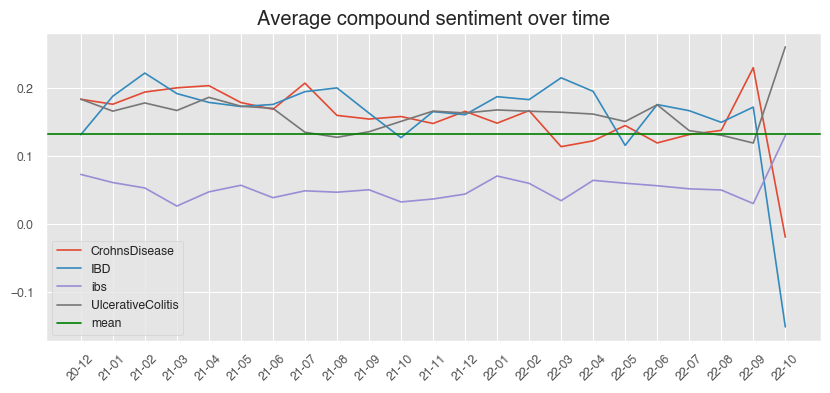

In [246]:
fig, ax = plt.subplots(figsize=(10,4))
plt.title('Average compound sentiment over time')
sns.lineplot(x=df_crohns.groupby('created').count().compound.keys(), y=avg_sentiments_crohn, ax=ax, label='CrohnsDisease')
sns.lineplot(x=df_ibd.groupby('created').count().compound.keys(), y=avg_sentiments_ibd, ax=ax, label='IBD')
sns.lineplot(x=df_ibs.groupby('created').count().compound.keys(), y=avg_sentiments_ibs, ax=ax, label='ibs')
sns.lineplot(x=df_ulc.groupby('created').count().compound.keys(), y=avg_sentiments_ulc, ax=ax, label='UlcerativeColitis')
plt.xticks(rotation=45)
ax.set_xlabel('')
plt.axhline(mean([mean(avg_sentiments_crohn), mean(avg_sentiments_ibd), mean(avg_sentiments_ibs), mean(avg_sentiments_ulc)]), color='g', label='mean')

plt.legend()
plt.show();

In [237]:
cumulative_compounds = pd.DataFrame({
    'crohns_count': df_crohns.groupby('created').count().label,
    'ibd_count': df_ibd.groupby('created').count().label,
    'ibs_count': df_ibs.groupby('created').count().label,
    'ulc_count': df_ulc.groupby('created').count().label
})

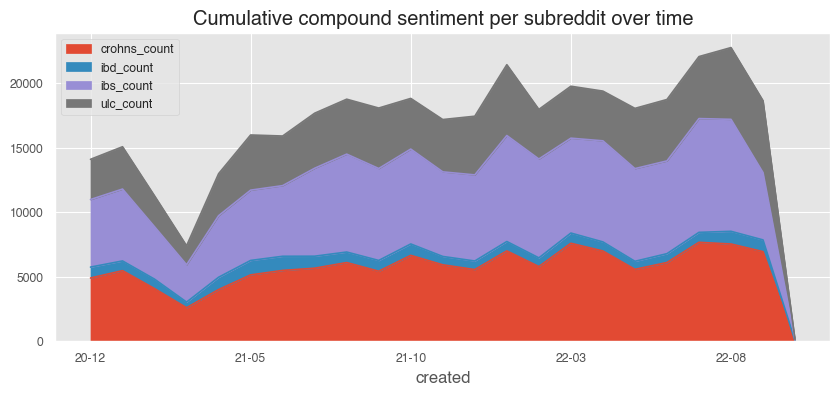

In [312]:
fig, ax = plt.subplots(figsize=(10,4))

cumulative_compounds.plot(kind='area', stacked='false', ax=ax)
ax.set_title('Cumulative compound sentiment per subreddit over time')
plt.show();

This area plot shows how ***r/UlcerativeColitis*** has the highest cumulative compound.  

**r/ibs** earns the second place but comparing with the results of the chart above, r/ibs has the lowest mean compound per month, the **saddest subreddit**... 

### Covid filtering and Analysis

In [299]:
covid_keywords = [
    "Pandemic",
    "pandemic",
    "coronavirus" ,
    "CORONAVIRUS",
    "Coronavirus",
    "COVID-19",
    "COVID19",
    "COVID",
    "COVID 19",
    "covid-19",
    "covid19",
    "covid",
    "cov",
    "covid 19",
    "Covid-19",
    "Covid19",
    "Covid",
    "Covid 19",
    "Vaccine",
    "vaccine"
    "SARS-COV-2",
    "SARS COV-2",
    "SARS-COV2",
    "SARS-COV 2",
    "SARS COV"
]

In [300]:
pattern = '|'.join([f'(?i){keyword}' for keyword in covid_keywords])

In [301]:
df_filtered = df[df.title_and_body.str.contains(pattern)]

In [302]:
df_filtered.shape[0]

19250

In [303]:
df_filtered = df_filtered[['id', 'author', 'title', 'body', 'title_and_body', 'score', 'num_comments', 'created', 'sia_vader', 'compound_vader', 'label_vader']]

In [304]:
df_filtered.created = df_filtered.created.apply(lambda x : x.strftime('%y-%m'))

cov_sentiment_by_month = df_filtered.groupby('created').sum('compound').compound_vader.values
cov_number_of_posts_over_time = df_filtered.groupby('created').count().compound_vader.values
cov_avg_sentiments = []
for i in range(0, len(cov_sentiment_by_month)):
    cov_avg_sentiments.append(cov_sentiment_by_month[i] / cov_number_of_posts_over_time[i])

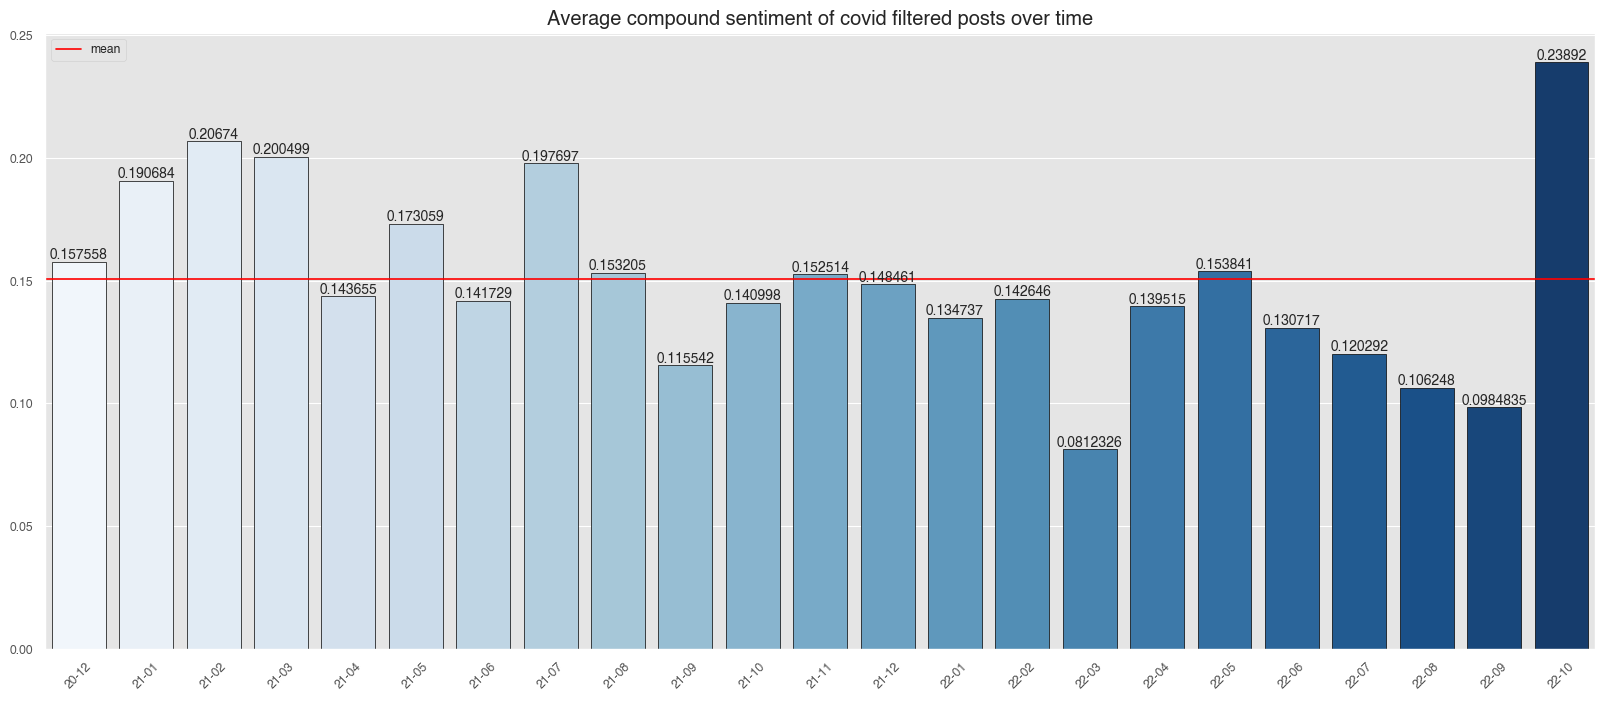

In [321]:
fig, ax = plt.subplots(figsize=(20,8))
plt.title('Average compound sentiment of covid filtered posts over time')
sns.barplot(x=df_filtered.groupby('created').count().compound_vader.keys(), y=cov_avg_sentiments, edgecolor='black', palette='Blues', ax=ax)
plt.xticks(rotation=45)
ax.set_xlabel('')
plt.axhline(mean(cov_avg_sentiments), color='r', label='mean')
ax.bar_label(ax.containers[0])

plt.legend(loc='upper left')
plt.show();

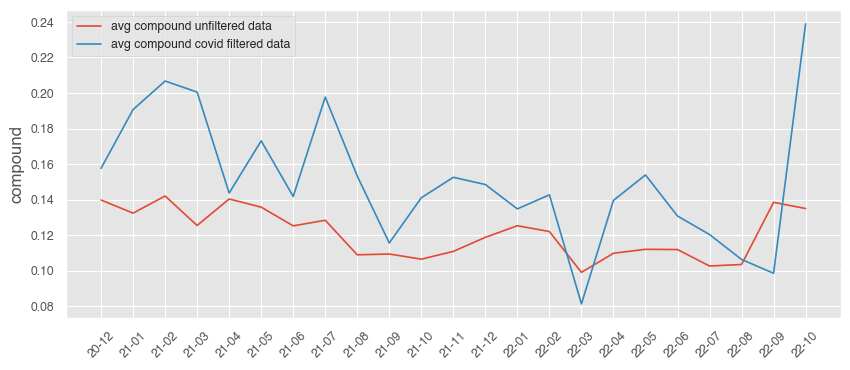

In [327]:
fig, ax = plt.subplots(figsize=(10,4))
sns.lineplot(x=df_vader.groupby('created').count().compound.keys(), y=avg_sentiments, ax=ax, label='avg compound unfiltered data')
sns.lineplot(x=df_filtered.groupby('created').count().compound_vader.keys(), y=cov_avg_sentiments, ax=ax, label='avg compound covid filtered data')
plt.xticks(rotation=45)
ax.set_xlabel('')
ax.set_ylabel('compound')
plt.show();